# Lab Assignment Two: Exploring Image Data

#### Machine Learning in Python

Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Business Understanding (20 points total).  
<em>
[<strong>20 points</strong>] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data. 
</em>

This dataset is a collection of images of alphabets from the American Sign Language. There are 29 classes associated with it, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE, and NOTHING. There are 3000 images for each class leading to this dataset containing over 80,000 images. For this lab, we are taking only a subset of these images. The classes we are looking at are A,B,C, and NOTHING. For A,B, and C, we are only using 300 images each while for NOTHING we are using 100 images. We then end up with 1000 images with four classes. We used these four to approximate the success we would have for the rest of the dataset. Because some of the computations seen in this lab are expensive, we focused on only a subset of classes. The data in this dataset is a very good representation of the American Sign Language. All the images vary in lightning, position of the hand, and angles. With such a varied dataset to train on, our program should be able to classify each hand no matter the variables. 

The data can be very useful in training a machine to learn American Sign Language. Over 5% of the world’s population, 466 million people, have disabling hearing loss as stated by the World Health Organization.  WHO also estimated that the number of people with hearing loss would increase in the later years. The end goal prediction task for this set is for the program to tell which of the four classes does each image represent. If we can produce an adequate measure of success for our dataset, third parties such as WHO, will be able to benefit from us. Communication between the hearing and non-hearing will be much easier. 

## Measure of Success

Now how do we determine if our machine learning algorithm is a success for this dataset. If our algorithm works well, we expect our success rate to be better than random guessing. Since there are four classes, a random guess would be right 25% of the time. Although we can’t achieve a 100% success rate, we hope to be at least above 80%. The people who have use of our case will be those of hearing. Since non-hearing will understand sign language and have no need for this algorithm, those with hearing will be able to communicate more effectively. They will have an easier method of understanding sign language. 

It would be okay for us to have some false negatives and false positives in classification since most humans can fill in the blanks given enough information. Although if our algorithm provides wrong classification too many times, some people might find it easier to manually type what they want to say so there is a balance between our algorithm being worth their time or just an encumbrance. 


#### Import Modules and Initialization

Before we begin, let's import essential packages for data analysis

In [1]:
import cv2
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import scatter
import numpy as np
import os
from random import randint
import seaborn as sns
from skimage import data, img_as_float
from skimage.feature import daisy
from skimage.measure import compare_ssim as ssim
import skimage.transform
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
import warnings

warnings.filterwarnings("ignore")

## Data Preparation (10 points total) 
<em>
[<strong>5 points</strong>] Read in your images as numpy arrays. Resize and recolor images as necessary. 
</em>

In [2]:
def load_images(class_name, count, size):
    img_list = []
    for i in range(count):
        img_path_string = 'asl_alphabet/'+class_name+'/'+class_name+str(i+1)+'.jpg'
        img = cv2.imread(img_path_string) # opens image using CV2
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts image to grayscale
        img = skimage.transform.resize(img, (size, size), mode='constant') # resizes image
        img = np.array(img*256, dtype=np.uint8)
        img_list.append(img)
    return img_list

img_size = 100
class_a = load_images('A', 300, img_size)
class_b = load_images('B', 300, img_size)
class_c = load_images('C', 300, img_size)
class_nothing = load_images('nothing', 100, img_size)

print(type(class_a[0]))
print(class_a[0].shape)

<class 'numpy.ndarray'>
(100, 100)


We created a function that loads our images, grayscales, resizes, then returns a list of numpy image arrays. We did this for 300 images of A, 300 images of B, 300 images of C, and 100 images of nothing, totalling 1000 images.

In [3]:
def linearization(class_list):
    for i in range(len(class_list)):
        class_list[i] = class_list[i].flatten()
    return class_list
    
class_a = linearization(class_a)
class_b = linearization(class_b)
class_c = linearization(class_c)
class_nothing = linearization(class_nothing)

print(class_a[0].shape)

(10000,)


After loading in the list of images, we then linearize the images into numpy vectors.

<em>
[<strong>1 points</strong>] Visualize several images.
</em>

In [4]:
class_list = class_a + class_b + class_c + class_nothing
class_titles = 300*['A'] + 300*['B'] + 300*['C'] + 100*['nothing']
# class_target = 300*[0] + 300*[1] + 300*[2] + 100*[3]

Cool! Now we have a compiled data frame with a list of images from all classes and their corresponding titles.

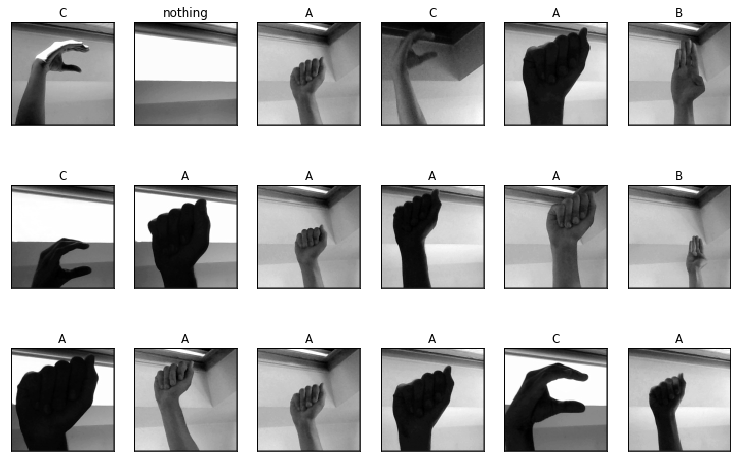

In [5]:
# a similar plotting function as seen in class; selects random images from dataset
def plot_gallery(images, titles, random=True, n_row=3, n_col=6):
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        if random:
            index = randint(1, len(images)-1)
        else:
            index = i
        plt.imshow(images[index].reshape((img_size, img_size)), cmap=plt.cm.gray)
        plt.title(titles[index], size=12)
        plt.xticks(())
        plt.yticks(())

        
plot_gallery(class_list, class_titles) 

## Data Reduction (60 points total)

<em>
[<strong>5 points</strong>] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.
</em>

Let's see if we can represent our dataset with only two principal components.

In [6]:
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(class_list.copy())
class_list_pca = pca.transform(class_list)

print ('pca:', pca.components_)

pca: [[-6.55649363e-05  3.56179063e-05 -2.61112926e-06 ... -3.94506476e-03
  -4.00315021e-03 -1.94221243e-03]
 [-2.52819833e-05  6.73654573e-06 -4.05546717e-05 ... -2.09409916e-03
  -2.16110681e-03 -1.05453716e-03]]


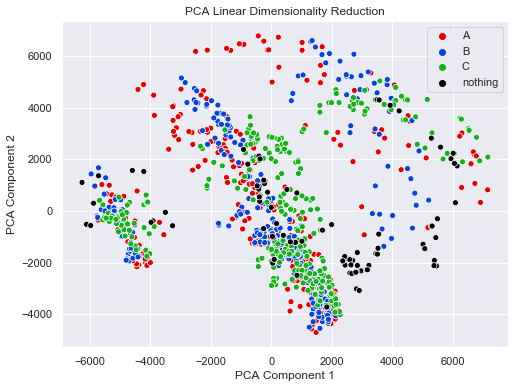

In [7]:
sns.set(style="darkgrid") 
plt.figure(figsize=(8,6))

colors = ['#e50000','#0343df','#15b01a','black']

sns.scatterplot(class_list_pca[:,0], class_list_pca[:,1], hue=class_titles, palette=colors)
plt.title('PCA Linear Dimensionality Reduction')
plt.xlabel('PCA Component 1') 
plt.ylabel('PCA Component 2')
plt.show()

As we can see in the graph above, there really isn't any defined group. The principal components aren't linearly seperable so we can't use this information to create an effective classifier. Let's increase the number of components to get a better explained variance in the data.

In [8]:
n_components = 100
pca = PCA(n_components=n_components)
%time pca.fit(class_list.copy())
eigenhands = pca.components_.reshape((n_components, img_size, img_size))

CPU times: user 2.48 s, sys: 224 ms, total: 2.7 s
Wall time: 584 ms


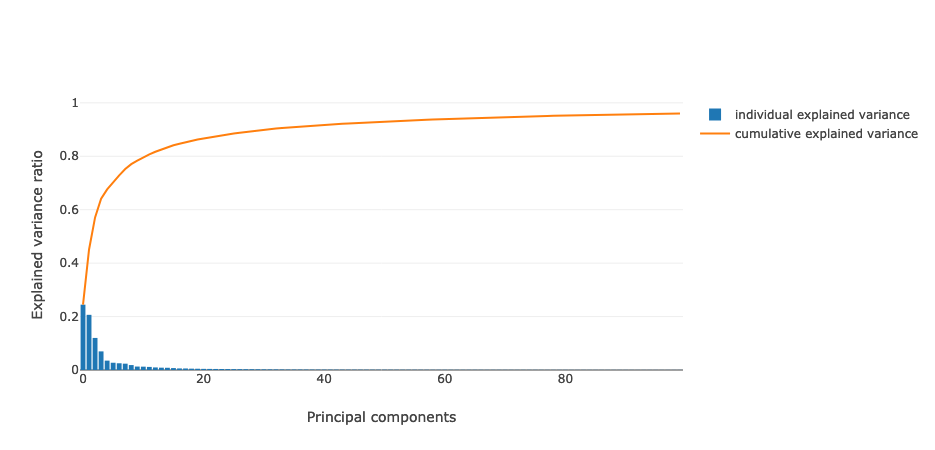

In [9]:
# manipulated from Sebastian Raschka Example
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html

def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

plot_explained_variance(pca)

As you can see in the graph, the explained variance ratio starts to plateau around 100 components. Resultantly, an increased number of principal components will only yield diminishing returns. Based on this reasoning, we are choosing our number of components to be 100.

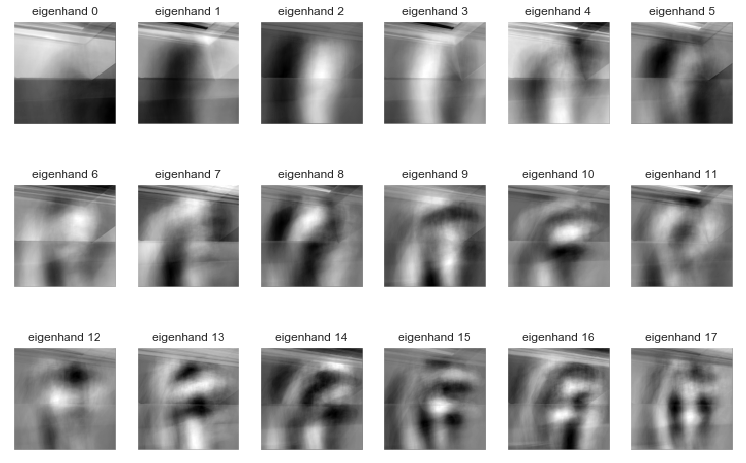

In [10]:
eigenhand_titles = ["eigenhand %d" % i for i in range(eigenhands.shape[0])]
plot_gallery(eigenhands, eigenhand_titles, random=False)

<em>
[<strong>5 points</strong>] Perform non-linear dimensionality reduction of your image data.
</em>

In [11]:
%%time
n_components = 100

kpca = KernelPCA(n_components=n_components, 
                kernel='rbf', 
                fit_inverse_transform=True, 
                gamma=12,
                remove_zero_eig=True
                )  
kpca.fit(class_list.copy())

CPU times: user 1.72 s, sys: 61.2 ms, total: 1.78 s
Wall time: 516 ms


We used a radial based function Kernel PCA to do non-linear dimensionality reduction of our image data. We did this with a total of 100 components based on our plotted explained variance. Below, we shall then reconstruct images using Full PCA and Kernel PCA and see which method better represents our images with fewer components.

<em>
[<strong>20 points</strong>] Compare the representation using non-linear dimensions to using linear dimensions. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components. Be aware that mean-squared error may not be a good measurement for kPCA.  Do you prefer one method over another? Why?
</em>

In [12]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image

Allows us to reconstruct our images using either Full PCA or Kernel PCA.

In [13]:
kpca_list = []
pca_list = []
n_list = []
S1=0
S2=0
for img in range (len(class_list)): 
    ldm, reconstructed_image = reconstruct_image(pca,class_list[img].reshape(1, -1))
    ldm, kernel_reconstructed_image = reconstruct_image(kpca,class_list[img].reshape(1, -1))
    normal_kpca = preprocessing.normalize(kernel_reconstructed_image.reshape((img_size, img_size)), norm='l2')
    normal_pca = preprocessing.normalize(reconstructed_image.reshape((img_size, img_size)), norm='l2')
    normal_pic = preprocessing.normalize(class_list[img].reshape(img_size, img_size), norm='l2')
    S1+=ssim(normal_pic,normal_pca)
    S2+=ssim(normal_pic,normal_kpca)

avg_S1 = S1/len(class_list)
avg_S2 = S2/len(class_list)



Since we are using kPCA, we decided not to use mean-squared error to measure the succes of our dimensionality methods. One reason is if we did a pixel by pixel compariosn, we would get a huge mean squared error due to the pixels being squished together.

Instead we decided to use ssim, structural similarity index which is built into skimage. We used this because it can sturcturally tell how similar each pixel is to another no matter how different they are.

In order to use ssim, we had to normalize all the images using preprocessing from sklearn. Then we find the ssim score of both Full PCA reconstructed image and Kernel PCA reconstructed image when compared to the non dimentionality reduced image. Then we add each score up seperately and divide it by the total number of images to get an average ssim score.

This takes about 20 seconds to run.

The average ssim score of the actual image and reconstructed PCA version:  0.9840190286501661
The average ssim score of the actual image and reconstructed Kenrel PCA version:  0.9374073444001436


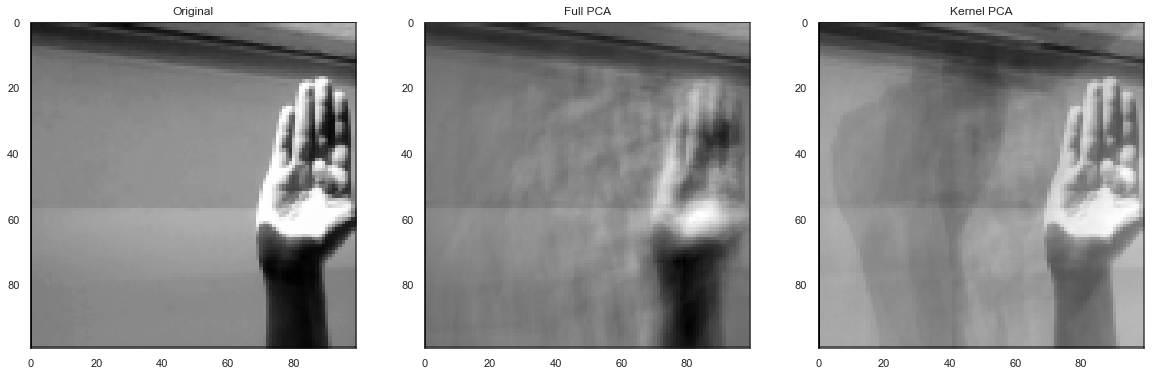

In [14]:
print("The average ssim score of the actual image and reconstructed PCA version: ", avg_S1)
print("The average ssim score of the actual image and reconstructed Kenrel PCA version: ", avg_S2)
LDM, ri = reconstruct_image(pca,class_list[300].reshape(1, -1))
LDM, kri = reconstruct_image(kpca,class_list[300].reshape(1, -1))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(class_list[300].reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,3,2)
plt.imshow(ri.reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Full PCA')
plt.grid()
plt.subplot(1,3,3)
plt.imshow(kri.reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title('Kernel PCA')
plt.grid()

In the end, we see that, on average, Full PCA has better score than Kernel PCA. Although in the images above, we can see that Kernel PCA did a better job at reconstructing the image than Full PCA. Since we can't look at everything the algorithm sees, we can only assume that either, on average, PCA yields a higher ssim score algorithmically or, on occasion, KPCA completely flops. Because the successful results of KPCA yield strong representations, we prefer using KPCA instead of Full PCA for this dataset.

<em>
[<strong>10 points</strong>] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).
</em>

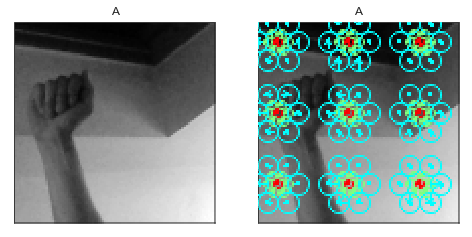

In [15]:
features, img_desc = daisy(
    class_list[0].reshape((img_size, img_size)),
    step=35, 
    radius=10, 
    rings=2, 
    histograms=6, 
    orientations=8, 
    visualize=True
)

plt.figure(figsize=(8,6))

plt.subplot(1,2,1)
plt.imshow(class_list[0].reshape((img_size, img_size)), cmap=plt.cm.gray)
plt.title(class_titles[0], size=12)
plt.xticks(())
plt.yticks(())
plt.grid()

plt.subplot(1,2,2)
plt.imshow(img_desc, cmap=plt.cm.gray)
plt.title(class_titles[0], size=12)
plt.xticks(())
plt.yticks(())
plt.grid()

For our feature extraction, we decided to use DAISY. We will use these extracted features to soon classify our dataset.

In [16]:
def apply_daisy(row, img_size):
    features = daisy(
        row.reshape(img_size, img_size),
        step=10, 
        radius=10, 
        rings=2, 
        histograms=6, 
        orientations=8, 
        visualize=False
    )
    return features.reshape((-1))

%time daisy_features = [apply_daisy(class_list[i], img_size) for i in range(len(class_list))]

CPU times: user 12.7 s, sys: 63.6 ms, total: 12.7 s
Wall time: 12.3 s


In [17]:
print('shape of daisy_features: (', len(daisy_features), ',', len(daisy_features[0]), ')')

shape of daisy_features: ( 1000 , 6656 )


Awesome! We got our features from all the images! Now on to classification.

<em>
[<strong>20 points</strong>] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.  
</em>

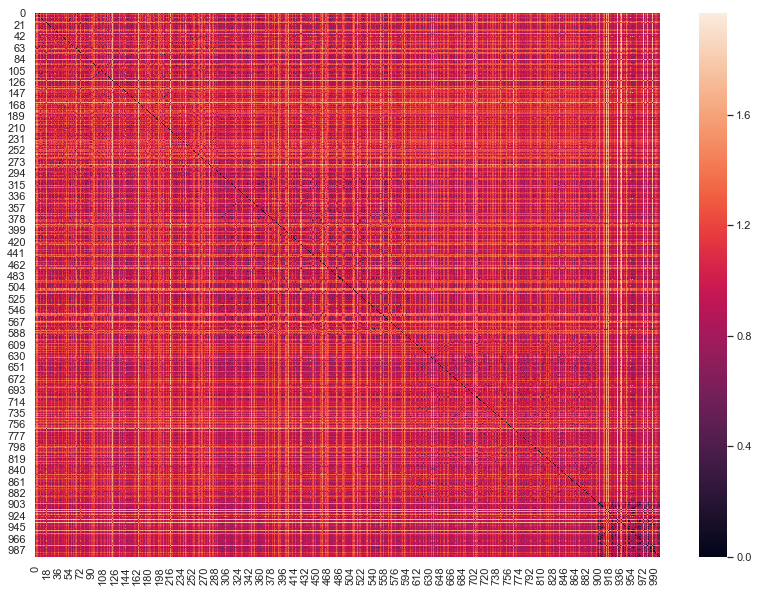

In [18]:
matrix = pairwise_distances(daisy_features)

plt.figure(figsize=(14,10))
ax = sns.heatmap(matrix)
plt.show()


Woah. Well, that's overwhelming. It's hard to conclude anything using this heat map. Upon close inspection we can kind of make out that there is a high correlation for our last 100 images, the <strong>nothing</strong> class. We can kind of see that for the 300, 600, 900 image tick mark, the plaid texture of the map slightly changes. But let's not fool ourselves, it's pretty much impossible to infer anything except that an image is most correlated with itself. 

Let's make a nearest neighbor classifier to see if the DAISY features are useful, despite the lack of obvious correlation

In [19]:
def build_knn(data, target, neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(data, target) 
    return knn

def predict_knn(data, target, knn):
    correct = 0
    for i in range(len(data)):
        y = knn.predict(data[i])
        if y == target[i]:
            correct = correct + 1
    return correct / len(test_data);

training_data = class_a[0:290] + class_b[0:290] + class_c[0:290] + class_nothing[0:95]
training_target = 290*['A'] + 290*['B'] + 290*['C'] + 95*['nothing']

knn = build_knn(training_data, training_target, 4)

Here we begin to split our dataset into training and testing data. But to test how effective our DAISY features really are, lets first calculate the accuracy of image classification prior to taking the DAISY features.

In [20]:
test_data = class_a[290:300] + class_b[290:300] + class_c[290:300] + class_nothing[95:100]
test_target = 10*['A'] + 10*['B'] + 10*['C'] + 5*['nothing']

for i in range(len(test_data)):
    test_data[i] = test_data[i].reshape(1, -1)

accuracy = predict_knn(test_data, test_target, knn)

print(accuracy)

0.8285714285714286


Great. Seems like our data is classifiable by K-Means just on its own. It's not great, but it seems to work alright. Let's check DAISY.

In [21]:
training_data = daisy_features[0:290] + daisy_features[300:590] + daisy_features[600:890] + daisy_features[900:995]
training_target = 290*['A'] + 290*['B'] + 290*['C'] + 95*['nothing']

knn = build_knn(training_data, training_target, 4)

In [22]:
test_data = daisy_features[290:300] + daisy_features[590:600] + daisy_features[890:900] + daisy_features[995:1000]
test_target = 10*['A'] + 10*['B'] + 10*['C'] + 5*['nothing']

for i in range(len(test_data)):
    test_data[i] = test_data[i].reshape(1, -1)

accuracy = predict_knn(test_data, test_target, knn)

print(accuracy)

0.9142857142857143


Alright! Not bad! There is definitely an increase in classification accuracy using the extracted features from DAISY. It's not fantastic, but for only 300 images per class and no key point matching among the DAISY features, this is pretty good. Although, we can definitely do better. 

## Exceptional Work (10 points total)

<em>
[<strong>10 points</strong>] Perform feature extraction upon the images using a feature extractor that requires key point matching (such as SIFT/SURF/ORB or others). Then build a nearest neighbor classifier using a method appropriate for your chosen features. You will need to investigate appropriate methods for comparisons with your chosen feature extraction technique. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive).
</em>

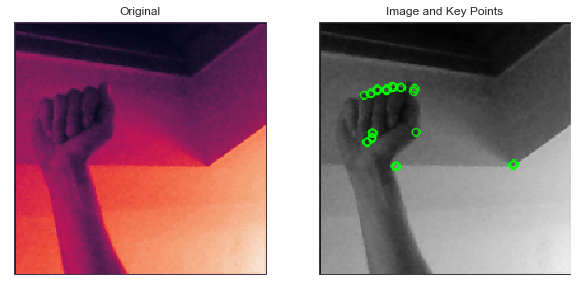

In [23]:
class_A = load_images(class_name='A', count=10, size=200)
class_B = load_images(class_name='B', count=10, size=200)
img = class_A[0]

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(img)
plt.xticks(())
plt.yticks(())
plt.title('Original')

# Initiate STAR detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp = orb.detect(img,None)

# compute the descriptors with ORB
kp, des = orb.compute(img, kp)

# draw only keypoints location,not size and orientation
img = cv2.drawKeypoints(img,kp,img,color=(0,255,0), flags=0)
plt.subplot(1,2,2)
plt.imshow(img)
plt.xticks(())
plt.yticks(())
plt.title('Image and Key Points')
plt.show()


First we will take each image and calculate its keypoints and descriptors. After doing this we will then be able to brute force match our features.

In [24]:
from PIL import Image

orb = cv2.ORB_create()

img1 = Image.open('asl_alphabet/A/A1.jpg')
img1 = img1.convert('L') # grayscales the image
img1 = np.asarray(img1) # converts image to numpy array

img2 = Image.open('asl_alphabet/A/A100.jpg')
img2 = img2.convert('L')
img2 = np.asarray(img2) # converts image to numpy array

kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

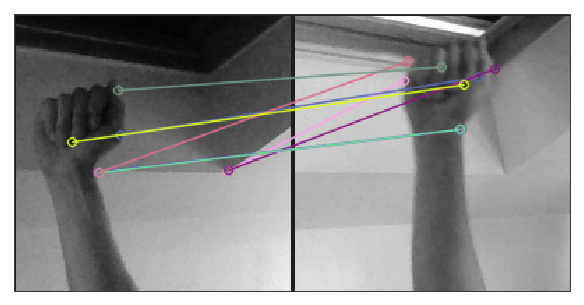

In [25]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)

plt.figure(figsize=(10,8))
plt.imshow(img3)
plt.xticks(())
plt.yticks(())
plt.show()

Ultimately, we ran out of time in executing the keypoint matching classifier. We tired implementing various libraries and even tried implementing the algorithm froms scratch. We wanted to collect all the image descritors and then take the minimum distance between one image's descriptors to another's. After taking the minimum distance and finding our most significant key points, we would then be able to run a nearest neighbor classifier on these descriptors for each class. 

After proving that this would work, we would then use the DAISY feature data collected from before. After running K-means on this dataset, we would be able to see an increase in accuracy from our DAISY classifier seen earlier. It would certainly be more accurate, as it would take into account the relative angle, scew, and size of the sign language whereas DAISY alone did not.

Unfortunately, in running out of time we were not able to gather our final classification metric for our measure of success. However, because we gathered a 91% accuracy through our DAISY nearest neighbor classifier, we were able to accomplish at least some level of success.